![image.png](attachment:image.png)

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



### Funciones y preparación de datos (código replicado de la solución del ejercicio de la primera unidad)

In [2]:
!mkdir data

In [3]:
!mv seg_train.zip ./data/

In [4]:
!mv seg_test.zip ./data

In [5]:
!unzip ./data/seg_train.zip -d ./data/

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ./data/seg_train/mountain/7539.jpg  
  inflating: ./data/seg_train/mountain/7551.jpg  
  inflating: ./data/seg_train/mountain/7560.jpg  
  inflating: ./data/seg_train/mountain/7565.jpg  
  inflating: ./data/seg_train/mountain/7578.jpg  
  inflating: ./data/seg_train/mountain/7581.jpg  
  inflating: ./data/seg_train/mountain/7586.jpg  
  inflating: ./data/seg_train/mountain/7647.jpg  
  inflating: ./data/seg_train/mountain/7652.jpg  
  inflating: ./data/seg_train/mountain/7654.jpg  
  inflating: ./data/seg_train/mountain/7662.jpg  
  inflating: ./data/seg_train/mountain/767.jpg  
  inflating: ./data/seg_train/mountain/7672.jpg  
  inflating: ./data/seg_train/mountain/7679.jpg  
  inflating: ./data/seg_train/mountain/7681.jpg  
  inflating: ./data/seg_train/mountain/7693.jpg  
  inflating: ./data/seg_train/mountain/7695.jpg  
  inflating: ./data/seg_train/mountain/7698.jpg  
  inflating: ./data/seg_train/mountain/7

In [6]:
!unzip ./data/seg_test.zip -d ./data/

Archive:  ./data/seg_test.zip
   creating: ./data/seg_test/
   creating: ./data/seg_test/buildings/
  inflating: ./data/seg_test/buildings/20057.jpg  
  inflating: ./data/seg_test/buildings/20060.jpg  
  inflating: ./data/seg_test/buildings/20061.jpg  
  inflating: ./data/seg_test/buildings/20064.jpg  
  inflating: ./data/seg_test/buildings/20073.jpg  
  inflating: ./data/seg_test/buildings/20074.jpg  
  inflating: ./data/seg_test/buildings/20078.jpg  
  inflating: ./data/seg_test/buildings/20083.jpg  
  inflating: ./data/seg_test/buildings/20094.jpg  
  inflating: ./data/seg_test/buildings/20096.jpg  
  inflating: ./data/seg_test/buildings/20113.jpg  
  inflating: ./data/seg_test/buildings/20131.jpg  
  inflating: ./data/seg_test/buildings/20140.jpg  
  inflating: ./data/seg_test/buildings/20177.jpg  
  inflating: ./data/seg_test/buildings/20186.jpg  
  inflating: ./data/seg_test/buildings/20206.jpg  
  inflating: ./data/seg_test/buildings/20207.jpg  
  inflating: ./data/seg_test/buil

In [7]:
!rm data/seg_train.zip

In [8]:
!rm data/seg_test.zip

In [ ]:
!mv ./data/seg_train.zip .

In [ ]:
!mv ./data/seg_test.zip .

In [ ]:
#!rm data.zip
#!rm -dr data

In [9]:
### Carga de datos y preparación obtenidas del ejercicio de la unidad 1:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"


*Introducimos un parametro de control de la resolución, inicialmente a 32, pero que podamos tocar sin cambiar nada del resto del código para poder probar otras resoluciones*

In [10]:
IMG_WIDTH = IMG_HEIGHT = 75 # primero a 32, luego a 75

In [11]:

def read_data(directorio, reshape_dim = (IMG_WIDTH,IMG_HEIGHT)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])


In [12]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

sea
mountain
street
buildings
glacier
forest
sea
mountain
street
buildings
glacier
forest


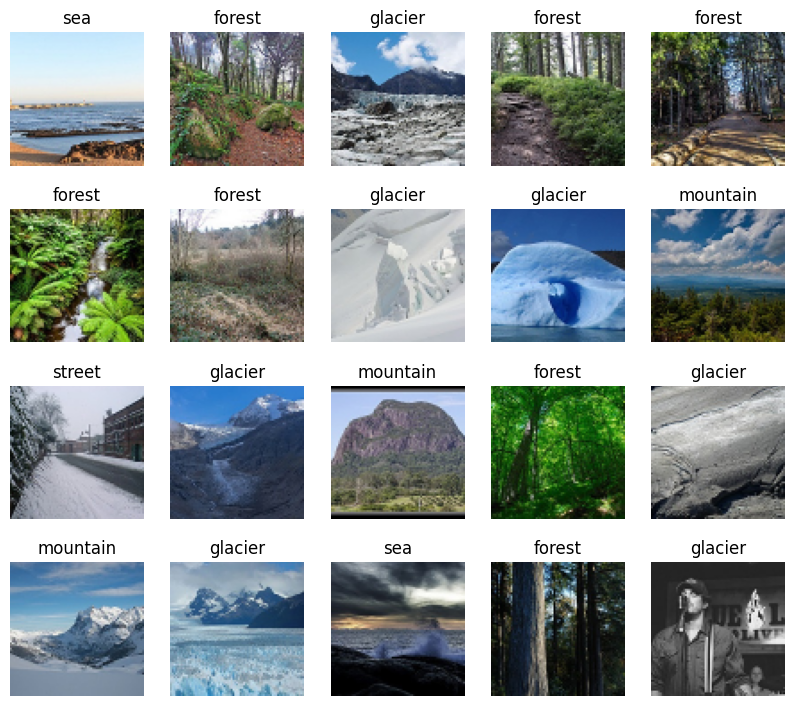

In [ ]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [13]:
from keras.applications.inception_v3 import preprocess_input


In [14]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

### Seleccion del modelo a transferir y tunear


*Escogemos el modelo de [Inception V3](https://arxiv.org/abs/1512.00567) el que tiene las supercapas convolucionales para hacer transfer learning*

In [ ]:
from keras.applications import InceptionV3

*Si investigas en la documentación del modelo verás que no puede admite resoluciones de entrada inferiores a 75x75*

### Transfer Learning

*Para el transfer learning vamos a usar una cabeza con una única capa densa con tantas unidades como el aplanamiento de las imagenes, es decir dependiendo de la resolución con la que hayamos cargado las imágenes al principio así tendremos una cantidad u otra de unidades*

In [ ]:
X_train.size

236823750

In [ ]:
X_train.shape

(14034, 75, 75, 3)

*El train tiene un tamaño más que considerable para aplicar un Adam y eso vamos a hacer, en principio sin tocar nada más*

In [ ]:
IMG_WIDTH = IMG_HEIGHT = 75
# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False


# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)

    # Tantas unidades como el flatten de la salida de Inception -> 5625 features
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc']) # sparse -> y es un array de escalares pero hay varias categorias, y un array de vectores
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 37, 37, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 37, 37, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 37, 37, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 35, 35, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 35, 35, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 35, 35, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 35, 35, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 35, 35, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 35, 35, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 17, 17, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 17, 17, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 17, 17, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 15, 15, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 15, 15, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

*Ahora vamos a configurar el resto de hiperparámetros, el batch_size, el número de épocas y el EarlyStopping*

In [ ]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 439
Batch_size: 64, num_steps_per_epoch: 219
Batch_size: 96, num_steps_per_epoch: 146
Batch_size: 128, num_steps_per_epoch: 110


*Podemos atrevernos hasta con batches de 128, para saber cuál usar vamos a hacer un entrenamiento de una época con cada uno y ver tiempos*

*Antes tendremos que convertir las etiquetas a números*

In [15]:
targets = pd.Series(y_train)

In [16]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Reusando la serie que creamos para ver la distribución del target
mapa

{'sea': 0,
 'mountain': 1,
 'street': 2,
 'buildings': 3,
 'glacier': 4,
 'forest': 5}

In [17]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [ ]:
from time import time
for batch_size in [32,64,96,128]:
    t_zero = time()
    model = prepare_model()
    history = model.fit(X_train,
                        y_train_num,
                        batch_size = batch_size,
                        validation_split=0.2,
                        epochs=1,)
    tiempo = round(time() - t_zero, 3)
    print(f"batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {tiempo}, tiempo 20 épocas: {tiempo * 20}")


351/351 ━━━━━━━━━━━━━━━━━━━━ 184s 499ms/step - acc: 0.7211 - loss: 0.8109 - val_acc: 0.1407 - val_loss: 8.7224
batch_size: 32, num_steps: 438.5625, tiempo 1 epoca: 186.658, tiempo 20 épocas: 3733.16
176/176 ━━━━━━━━━━━━━━━━━━━━ 168s 908ms/step - acc: 0.7066 - loss: 0.7939 - val_acc: 0.1546 - val_loss: 10.5641
batch_size: 64, num_steps: 219.28125, tiempo 1 epoca: 212.212, tiempo 20 épocas: 4244.24
117/117 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - acc: 0.6823 - loss: 0.8432 - val_acc: 0.1664 - val_loss: 10.9802
batch_size: 96, num_steps: 146.1875, tiempo 1 epoca: 165.616, tiempo 20 épocas: 3312.32
88/88 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - acc: 0.6516 - loss: 1.0086 - val_acc: 0.1364 - val_loss: 8.8388
batch_size: 128, num_steps: 109.640625, tiempo 1 epoca: 213.558, tiempo 20 épocas: 4271.16


*Vamos a por los 128 de batch size*

In [ ]:
batch_size

128

In [ ]:
earlyS = keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True)

In [ ]:
from sklearn.utils import shuffle
X_train_s,y_train_s = shuffle(X_train, y_train_num)

In [ ]:
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s,
                    y_train_s,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=40,
                    callbacks = [earlyS])
tiempo = round(time() - t_zero, 3)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - acc: 0.6236 - loss: 1.0854 - val_acc: 0.7535 - val_loss: 0.6344
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - acc: 0.8291 - loss: 0.4781 - val_acc: 0.7731 - val_loss: 0.6022
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - acc: 0.8747 - loss: 0.3575 - val_acc: 0.7724 - val_loss: 0.6240
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.9135 - loss: 0.2591 - val_acc: 0.7830 - val_loss: 0.6223
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - acc: 0.9516 - loss: 0.1673 - val_acc: 0.7834 - val_loss: 0.6668
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - acc: 0.9746 - loss: 0.1047 - val_acc: 0.7770 - val_loss: 0.7220
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - acc: 0.9907 - loss: 0.0597 - val_acc: 0.7802 - val_loss: 0.7552
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - acc: 0.9947 - loss: 0.0396 - val_acc: 0.7781 - val_loss: 0.7978
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - acc: 0.9956

*Evaluamos*

In [ ]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - acc: 0.7616 - loss: 0.6426


[0.6118523478507996, 0.7743333578109741]

*Un 78% que es un 2% mejor que la convolucional "sencilla", no es mucha ganancia para tanto armatoste. ¿Podríamos mejorar la cabeza decisora?*

*Completemos con el análisis del informe de clasificación y de la matriz de confusión*

In [ ]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 343ms/step


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.87      0.77      0.81       437
      forest       0.93      0.96      0.94       474
     glacier       0.76      0.58      0.66       553
    mountain       0.66      0.70      0.68       525
         sea       0.68      0.84      0.75       510
      street       0.81      0.84      0.83       501

    accuracy                           0.77      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.77      0.77      3000



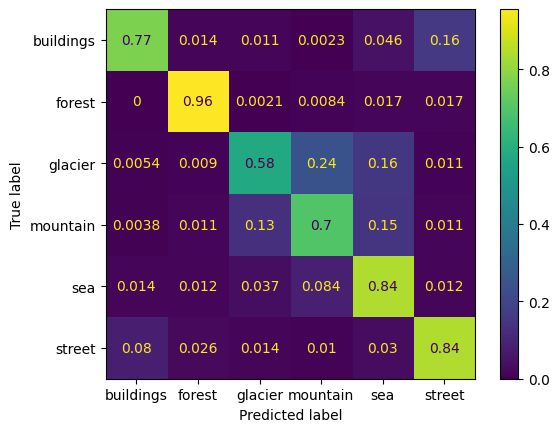

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

*Confunde montañas con glaciares y viceversa (las clases peor paradas), aunque las montañas también las confunde con el mar. Es peor en las montañas que el clasificador del ejercicio pero mejor sensiblemente en los edificios y mejor en los glaciares (las dos clases "malas" del clasificador de los ejercicios). Al igual que el clasificador del ejercicio confunde calles con edificios.*

### Fine-Tuning

*Mantenemos la Inception V3**

In [ ]:
#del imread, train_test_split, shuffle

In [ ]:
#
from keras.applications import InceptionV3
import keras


IMG_WIDTH = IMG_HEIGHT = 75

# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights=None, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Congelamos sus capas
#for layer in base_model.layers:
#    layer.trainable = False


# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)

    # Tantas unidades como el flatten de la salida de Inception
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)


    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 37, 37, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 37, 37, 32)     │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 37, 37, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 35, 35, 32)     │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 35, 35, 32)     │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 35, 35, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 35, 35, 64)     │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 35, 35, 64)     │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 35, 35, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 17, 17, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 17, 17, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 17, 17, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 25,976,998 (99.09 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
from time import time
for batch_size in [32,64,96,128]:
    t_zero = time()
    model = prepare_model()
    history = model.fit(X_train_s,
                        y_train_s,
                        batch_size = batch_size,
                        validation_split=0.2,
                        epochs=1,)
    tiempo = round(time() - t_zero, 3)
    print(f"batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {tiempo}, tiempo 20 épocas: {tiempo * 20}")

351/351 ━━━━━━━━━━━━━━━━━━━━ 772s 2s/step - acc: 0.4441 - loss: 1.8328 - val_acc: 0.2943 - val_loss: 2.4254
batch_size: 32, num_steps: 438.5625, tiempo 1 epoca: 775.805, tiempo 20 épocas: 15516.099999999999
176/176 ━━━━━━━━━━━━━━━━━━━━ 747s 4s/step - acc: 0.3996 - loss: 2.0641 - val_acc: 0.3082 - val_loss: 16.2151
batch_size: 64, num_steps: 219.28125, tiempo 1 epoca: 792.908, tiempo 20 épocas: 15858.16
117/117 ━━━━━━━━━━━━━━━━━━━━ 715s 6s/step - acc: 0.3539 - loss: 1.9060 - val_acc: 0.2077 - val_loss: 18.5261
batch_size: 96, num_steps: 146.1875, tiempo 1 epoca: 717.547, tiempo 20 épocas: 14350.94
88/88 ━━━━━━━━━━━━━━━━━━━━ 733s 8s/step - acc: 0.4538 - loss: 1.3389 - val_acc: 0.2554 - val_loss: 22.5180
batch_size: 128, num_steps: 109.640625, tiempo 1 epoca: 794.38, tiempo 20 épocas: 15887.6


*Mantenemos el batch_size en 128*

*Lanzamos el fine-tuning y a esperar*

In [ ]:
from time import time
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s,
                    y_train_s,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=40,
                    callbacks = [earlyS])
tiempo = round(time() - t_zero, 3)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 721s 8s/step - acc: 0.3880 - loss: 2.1674 - val_acc: 0.1810 - val_loss: 1.9346
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 678s 8s/step - acc: 0.6483 - loss: 0.9646 - val_acc: 0.1767 - val_loss: 2.9069
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 682s 8s/step - acc: 0.6775 - loss: 0.8868 - val_acc: 0.2366 - val_loss: 2.7466
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 695s 8s/step - acc: 0.7524 - loss: 0.6977 - val_acc: 0.4403 - val_loss: 1.6490
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 687s 8s/step - acc: 0.7893 - loss: 0.6063 - val_acc: 0.6299 - val_loss: 1.1498
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 686s 8s/step - acc: 0.8163 - loss: 0.5348 - val_acc: 0.7072 - val_loss: 0.8944
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 740s 8s/step - acc: 0.8303 - loss: 0.5076 - val_acc: 0.7203 - val_loss: 0.8772
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 755s 8s/step - acc: 0.8534 - loss: 0.4379 - val_acc: 0.7435 - val_loss: 0.8409
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 732s 8s/step - acc: 0.8556

In [ ]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 324ms/step - acc: 0.8409 - loss: 0.5292


[0.6166930794715881, 0.8149999976158142]

*Bueno, un 80%, 4 pp. mejor que el modelo con dos capas convolucionales,... ¿merece la pena el esfuerzo?*

In [ ]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 364ms/step


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.80      0.75      0.77       437
      forest       0.91      0.94      0.93       474
     glacier       0.81      0.78      0.79       553
    mountain       0.70      0.84      0.76       525
         sea       0.86      0.75      0.80       510
      street       0.83      0.83      0.83       501

    accuracy                           0.81      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.81      0.82      3000



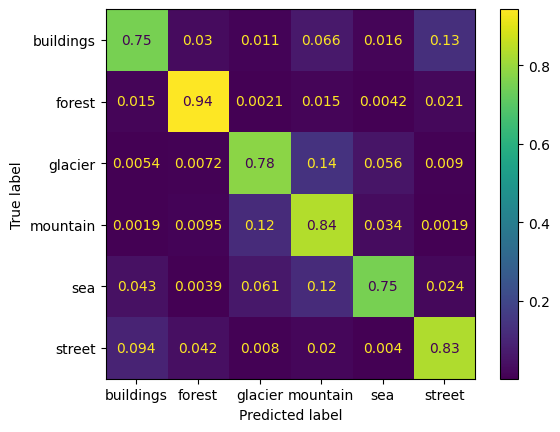

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

*El modelo completo ha mejorado en las que era peor el anterior pero a costa de empeorar en edificios y calles que ahora se confunden no solo entre ellos sino que un poco con todos.*

*El modelo fine-tuneado mejora en casi todo al modelo inicial, salvo en la detección de street y ligeramente en las montañas*

### EXTRA

*Vamos a repetir la parte de trasnfer learning pero utilizando aumentado de imágenes a ver si mejoramos algo más*

In [18]:
ficheros = []
clases = []
for directorio in os.listdir(TRAIN_PATH):
    clase = directorio
    ficher = [TRAIN_PATH + directorio + "/" + fichero for fichero in os.listdir(TRAIN_PATH + directorio)]
    clases += [clase for fichero in ficher]
    ficheros += ficher
train_augmented = pd.DataFrame({"filename": ficheros,"category": clases})
train_augmented.head(10)

,filename,category
0,./data/seg_train/sea/2486.jpg,sea
1,./data/seg_train/sea/11033.jpg,sea
2,./data/seg_train/sea/15011.jpg,sea
3,./data/seg_train/sea/6538.jpg,sea
4,./data/seg_train/sea/17902.jpg,sea
5,./data/seg_train/sea/248.jpg,sea
6,./data/seg_train/sea/16276.jpg,sea
7,./data/seg_train/sea/9514.jpg,sea
8,./data/seg_train/sea/19282.jpg,sea
9,./data/seg_train/sea/19068.jpg,sea


In [31]:
def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

 # Para escalar entre -1 y 1, como necesita esta red

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=prep_fn,
    rotation_range=15, # Angulo de rotación
    rescale=1, # Escalado
    shear_range=0.1, # Inclina las imágenes, no es giro es inclinación como hacerlas "cursivas"
    zoom_range=0.2, # Zoom
    horizontal_flip=True, # giro horizontal o especular
    width_shift_range=0.1, # Desplazamiento horizontal de los pixeles
    height_shift_range=0.1 # Desplazamiento vertical de los píxeles
)

In [33]:
train_df, validate_df = train_test_split(train_augmented,
                                         test_size=0.20,stratify=train_augmented["category"],
                                         random_state=42)

In [21]:
train_df.head(10)

,filename,category
8077,./data/seg_train/buildings/3051.jpg,buildings
1726,./data/seg_train/sea/13858.jpg,sea
10109,./data/seg_train/glacier/7827.jpg,glacier
10275,./data/seg_train/glacier/9773.jpg,glacier
11834,./data/seg_train/forest/13923.jpg,forest
6882,./data/seg_train/street/16250.jpg,street
3564,./data/seg_train/mountain/6239.jpg,mountain
3849,./data/seg_train/mountain/9190.jpg,mountain
390,./data/seg_train/sea/17807.jpg,sea
11143,./data/seg_train/glacier/9974.jpg,glacier


In [22]:
validate_df.head()

,filename,category
12959,./data/seg_train/forest/19299.jpg,forest
11187,./data/seg_train/glacier/15152.jpg,glacier
4070,./data/seg_train/mountain/2569.jpg,mountain
7547,./data/seg_train/buildings/5533.jpg,buildings
9119,./data/seg_train/buildings/8777.jpg,buildings


In [23]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [34]:
batch_size = 128

In [35]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='sparse', # Porque es binaria, si fuera multiclase y en un sólo valor -> "sparse" (otras configuraciones, ver la documentación)
    batch_size= batch_size
)

Found 11227 validated image filenames belonging to 6 classes.


In [36]:
validation_datagen = ImageDataGenerator(preprocessing_function=prep_fn,rescale=1) # Solo vamos a reescalar, pero ya vienen reescaladas
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    x_col='filename',
    y_col='category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='sparse',
    batch_size= batch_size
)

Found 2807 validated image filenames belonging to 6 classes.


In [37]:
earlyS = keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True)

In [38]:
from keras.applications import InceptionV3
# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False


# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)

    # Tantas unidades como el flatten de la salida de Inception
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)


    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(base_model.input, x)
    #optimizer = keras.optimizers.Adam(learning_rate=1e-2) # 1e-3 "RMSProp"
    model.compile(optimizer ="Adam" , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model
# Observamos la arquitectura del modelo

In [39]:
model = prepare_model()
history = model.fit(
    train_generator,
    epochs= 100,
    validation_data=validation_generator,
    callbacks= earlyS
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.5615 - loss: 1.3667 - val_accuracy: 0.7542 - val_loss: 0.6492
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7385 - loss: 0.7126 - val_accuracy: 0.7706 - val_loss: 0.6221
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7628 - loss: 0.6455 - val_accuracy: 0.7724 - val_loss: 0.5972
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7661 - loss: 0.6310 - val_accuracy: 0.7848 - val_loss: 0.5722
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7717 - loss: 0.6123 - val_accuracy: 0.7866 - val_loss: 0.5564
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.7828 - loss: 0.5832 - val_accuracy: 0.7827 - val_loss: 0.5713
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.7876 - loss: 0.5672 - val_accuracy: 0.7884 - val_loss: 0.5531
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7853 - loss: 0.5658 - val_accuracy: 0.7955 - val_l

In [131]:
map_categories_generator = train_generator.class_indices

In [132]:
map_categories_generator

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [135]:
y_test_num_generator = np.array([map_categories_generator[y] for y in y_test])


In [136]:
model.evaluate(X_test, y_test_num_generator)

94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 298ms/step - accuracy: 0.7920 - loss: 0.5571


[0.5243900418281555, 0.8080000281333923]

In [137]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 322ms/step


In [139]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map_generator = {valor:clave for clave,valor in map_categories_generator.items()}
y_test_labels = [inverse_map_generator[y] for y in y_test_num_generator]
y_pred_labels = [inverse_map_generator[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.83      0.83      0.83       437
      forest       0.96      0.93      0.94       474
     glacier       0.78      0.72      0.75       553
    mountain       0.71      0.75      0.73       525
         sea       0.80      0.79      0.80       510
      street       0.79      0.85      0.82       501

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



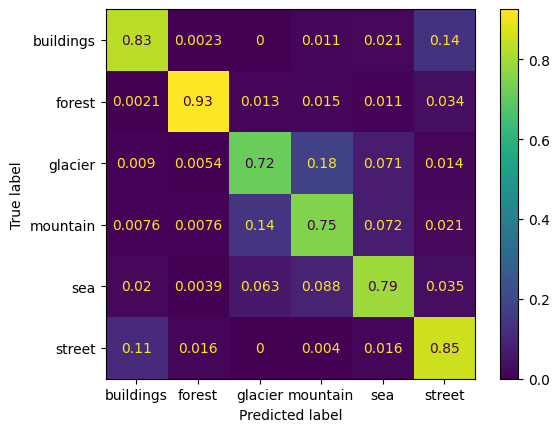

In [140]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")